In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv('dataset_elpino.csv', delimiter=';')

# Mostrar las primeras filas para entender la estructura
print(df.head())

                         Diag 01 Principal (cod+des)  \
0            A41.8 - Otras septicemias especificadas   
1               U07.1 - COVID-19, virus identificado   
2  K56.5 - Adherencias [bridas] intestinales con ...   
3  K76.8 - Otras enfermedades especificadas del h...   
4  T81.0 - Hemorragia y hematoma que complican un...   

                        Diag 02 Secundario (cod+des)  \
0     B37.6 - Endocarditis debida a candida (I39.8*)   
1              J12.8 - Neumonía debida a otros virus   
2                              R57.2 - Shock séptico   
3                              K66.1 - Hemoperitoneo   
4  Y83.2 - Operación quirúrgica con anastomosis, ...   

                        Diag 03 Secundario (cod+des)  \
0  I39.8 - Endocarditis, válvula no especificada,...   
1                                     R06.0 - Disnea   
2                        R57.1 - Choque hipovolémico   
3        N18.5 - Enfermedad renal crónica, estadio 5   
4               S31.1 - Herida de la pared abd

/var/folders/cd/4pzqn3ks6v72bm6m05z1rv600000gn/T/ipykernel_67945/453745165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sexo (Desc)', palette='pastel')


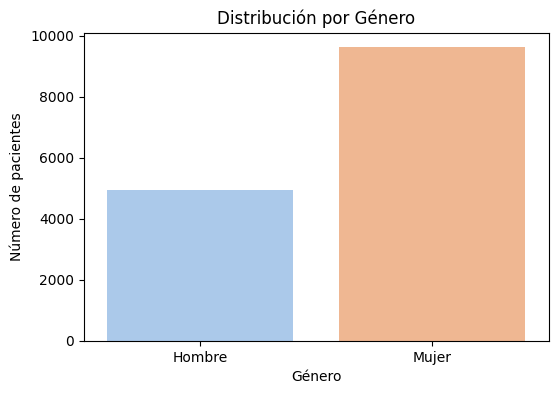

In [52]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sexo (Desc)', palette='pastel')
plt.title('Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Número de pacientes')
plt.show()

/var/folders/cd/4pzqn3ks6v72bm6m05z1rv600000gn/T/ipykernel_67945/602517200.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


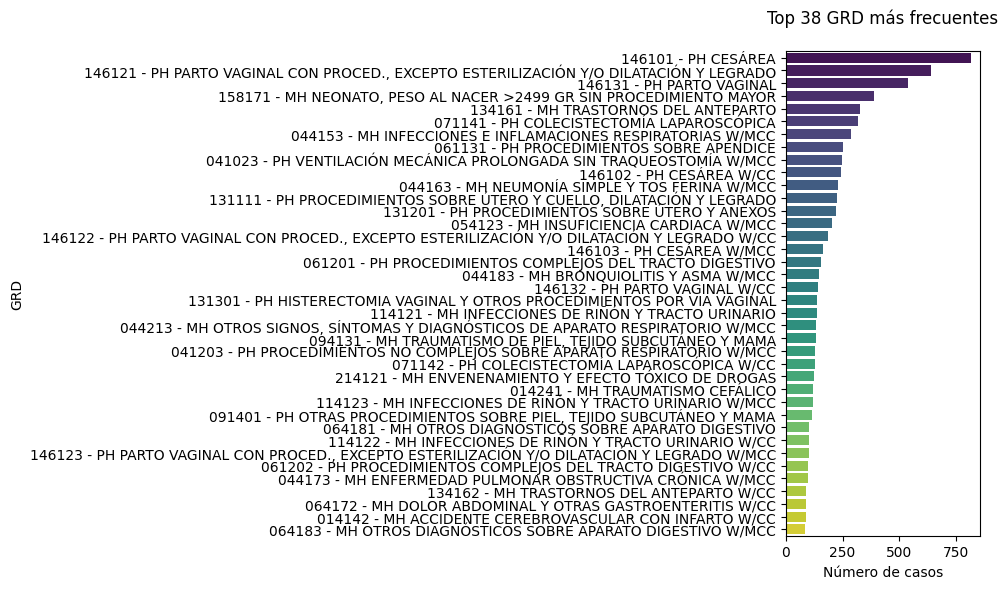

In [53]:
top_n = 38  # Mostrar solo los 10 GRD más comunes
top_grd = df['GRD'].value_counts().head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_grd.values,
    y=top_grd.index,
    palette='viridis'
)
plt.title(f'Top {top_n} GRD más frecuentes', pad=20)
plt.xlabel('Número de casos')
plt.ylabel('GRD')
plt.tight_layout()
plt.show()

In [54]:
from collections import Counter

# Filtrar solo los GRDs de cesárea
cesarea_grd = ['146101 - PH CESÁREA W/O CC',
               '146102 - PH CESÁREA W/CC',
               '146103 - PH CESÁREA W/MCC']
df_cesarea = df[df['GRD'].isin(cesarea_grd)]

In [55]:
# Función para extraer procedimientos de una fila
def get_procedures(row):
    procedures = []
    for col in df.columns:
        if 'Proced' in col and pd.notna(row[col]):
            # Extraer código del procedimiento (primera parte antes del espacio)
            proc_code = row[col].split(' - ')[0]
            procedures.append(proc_code)
    return procedures

# Aplicar la función a cada fila
df_cesarea['Procedimientos'] = df_cesarea.apply(get_procedures, axis=1)

# Contar procedimientos por GRD
procedures_by_grd = {}
for grd in cesarea_grd:
    grd_df = df_cesarea[df_cesarea['GRD'] == grd]
    all_procedures = []
    for procedures in grd_df['Procedimientos']:
        all_procedures.extend(procedures)
    procedure_counts = Counter(all_procedures)
    procedures_by_grd[grd] = procedure_counts.most_common()

/var/folders/cd/4pzqn3ks6v72bm6m05z1rv600000gn/T/ipykernel_67945/913897013.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cesarea['Procedimientos'] = df_cesarea.apply(get_procedures, axis=1)


In [56]:
# Leer el archivo CSV
df = pd.read_csv('dataset_elpino.csv', delimiter=';')

# Filtrar solo los GRDs de cesárea
cesarea_grd = ['146101 - PH CESÁREA',
               '146102 - PH CESÁREA W/CC',
               '146103 - PH CESÁREA W/MCC']
df_cesarea = df[df['GRD'].isin(cesarea_grd)].copy()

# Mostrar cuántos registros hay para cada GRD
print("Cantidad de casos por GRD:")
print(df_cesarea['GRD'].value_counts())
print("\n")

def get_procedures(row):
    procedures = []
    for col in df.columns:
        if 'Proced' in col and pd.notna(row[col]) and row[col].strip() != "-":
            # Extraer código del procedimiento (primera parte antes del espacio)
            proc_code = row[col].split(' - ')[0]
            procedures.append(proc_code)
    return procedures

# Aplicar la función a cada fila para obtener todos los procedimientos
df_cesarea['Procedimientos'] = df_cesarea.apply(get_procedures, axis=1)

# Contar procedimientos por GRD
procedures_by_grd = {}
for grd in cesarea_grd:
    grd_df = df_cesarea[df_cesarea['GRD'] == grd]
    all_procedures = []
    for procedures in grd_df['Procedimientos']:
        all_procedures.extend(procedures)
    procedure_counts = Counter(all_procedures)
    procedures_by_grd[grd] = procedure_counts.most_common()

Cantidad de casos por GRD:
GRD
146101 - PH CESÁREA          813
146102 - PH CESÁREA W/CC     244
146103 - PH CESÁREA W/MCC    163
Name: count, dtype: int64




In [57]:
# Mostrar los resultados para cada GRD
for grd in cesarea_grd:
    print(f"Procedimientos más comunes para {grd}:")
    for proc, count in procedures_by_grd[grd][:10]:  # Mostrar top 10
        print(f"{proc}: {count} veces")
    print("\n")

# Visualización de resultados
grd_names = ['146101 (Sin CC)', '146102 (Con CC)', '146103 (Con MCC)']
top_procedures = {}

for grd in cesarea_grd:
    top_procedures[grd] = procedures_by_grd[grd][:5]  # Top 5 procedimientos

Procedimientos más comunes para 146101 - PH CESÁREA:
90.59: 816 veces
89.26: 813 veces
74.1: 810 veces
99.29: 801 veces
57.94: 788 veces
99.24: 719 veces
99.18: 687 veces
89.7: 569 veces
97.64: 540 veces
90.39: 489 veces


Procedimientos más comunes para 146102 - PH CESÁREA W/CC:
90.59: 248 veces
74.1: 244 veces
89.26: 244 veces
99.29: 241 veces
57.94: 236 veces
99.24: 212 veces
99.18: 204 veces
89.7: 181 veces
75.34: 177 veces
90.39: 158 veces


Procedimientos más comunes para 146103 - PH CESÁREA W/MCC:
90.59: 169 veces
74.1: 164 veces
57.94: 163 veces
89.26: 163 veces
99.29: 162 veces
99.24: 144 veces
90.39: 142 veces
99.18: 136 veces
75.34: 129 veces
99.19: 113 veces




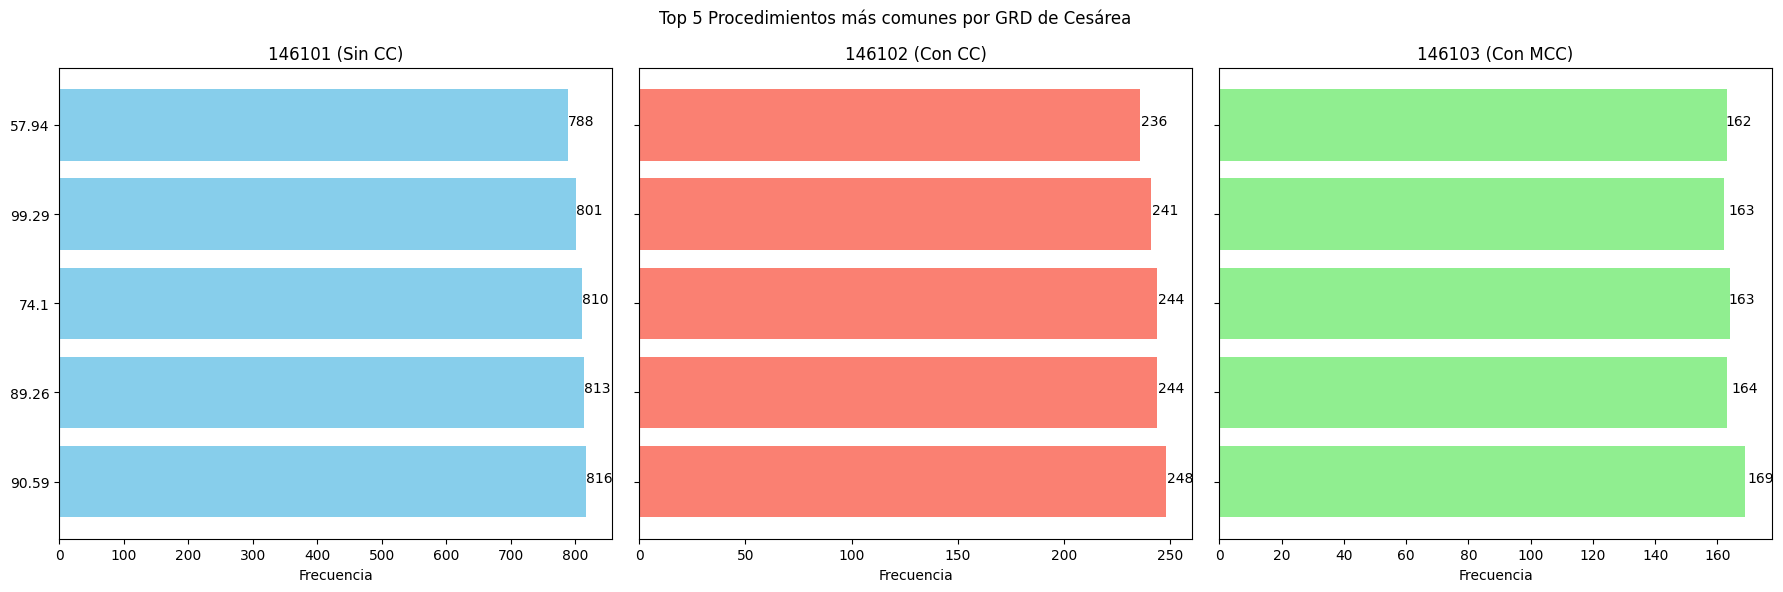

In [58]:
# Crear gráfico
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, grd in enumerate(cesarea_grd):
    procedures, counts = zip(*top_procedures[grd])
    axs[i].barh(procedures, counts, color=['skyblue', 'salmon', 'lightgreen'][i])
    axs[i].set_title(grd_names[i])
    axs[i].set_xlabel('Frecuencia')

    # Añadir etiquetas de valor
    for j, v in enumerate(counts):
        axs[i].text(v + 0.5, j, str(v), color='black')

plt.suptitle('Top 5 Procedimientos más comunes por GRD de Cesárea')
plt.tight_layout()
plt.show()

In [59]:
# Análisis adicional: comparar procedimientos entre diferentes niveles de severidad
print("Comparación de procedimientos entre diferentes niveles de severidad:")
common_procedures = set()

# Encontrar procedimientos comunes a todos los GRDs
for grd in cesarea_grd:
    procedures = [proc for proc, count in procedures_by_grd[grd]]
    if not common_procedures:
        common_procedures = set(procedures)
    else:
        common_procedures.intersection_update(procedures)

print("\nProcedimientos comunes a todos los GRDs:")
for proc in common_procedures:
    print(proc)

# Procedimientos exclusivos de cada GRD
for grd in cesarea_grd:
    other_grds = [g for g in cesarea_grd if g != grd]
    other_procedures = set()
    for other_grd in other_grds:
        other_procedures.update([proc for proc, count in procedures_by_grd[other_grd]])

    current_procedures = set([proc for proc, count in procedures_by_grd[grd]])
    exclusive_procedures = current_procedures - other_procedures

    print(f"\nProcedimientos exclusivos de {grd}:")
    for proc in exclusive_procedures:
        print(proc)

Comparación de procedimientos entre diferentes niveles de severidad:

Procedimientos comunes a todos los GRDs:
88.79
99.26
94.08
89.65
88.78
99.18
38.93
99.84
89.7
91.39
93.99
68.9
96.04
73.4
87.44
90.59
90.39
74.1
73.09
68.11
89.52
89.05
87.03
89.26
66.51
93.18
88.19
38.91
66.39
99.24
03.91
99.17
66.32
99.33
73.99
99.19
99.21
75.34
99.11
99.04
91.32
99.23
93.96
93.82
96.49
96.71
03.90
96.59
99.29
93.01
91.33
97.64
57.94
89.06

Procedimientos exclusivos de 146101 - PH CESÁREA:
88.38
90.35
54.63
75.32
73.01
88.44
75.99
93.17
99.39
96.48
72.8
93.59
89.39
03.31
57.95
69.29
69.49
75.69
72.9
57.93
66.52

Procedimientos exclusivos de 146102 - PH CESÁREA W/CC:
73.59
65.39
66.29
73.1
96.6
87.72
68.29
86.22
65.49
88.21

Procedimientos exclusivos de 146103 - PH CESÁREA W/MCC:
67.19
93.14
89.61
88.72
93.04
91.42
95.11
93.27
75.1
68.59
91.82
90.99
93.05
93.90
69.97
71.23
70.21
69.41
89.14
54.61
54.19
93.09
69.96
39.95
96.72
99.05
39.98
93.13
90.42
91.43
69.99
75.92
51.85
51.10
91.12
